<a href="https://colab.research.google.com/github/devdastl/EVA-8_Phase-1_Assignment-8/blob/main/eva8_assignment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Colab notebook contains Assignment 8 of EVA-8 from TSAI. For more information refer to github README.md file

### Pull main repo eva8_source.
[eva8_source](https://github.com/devdastl/eva8_source) used in this repo is upgraded version of the repo which was used in [assignment 7](https://github.com/devdastl/EVA-8_Phase-1_Assignment-7/blob/main/eva8_assignment_7.ipynb).

Following are the upgrades compared to the last version:

- Main model execution module `ModelExecuter` which runs Epoch loop as well with utility function integrated.
- LRFinder and OneCycleLR pocliy support integrated with `ModelExecuter` unit

In [1]:
import os
# !git clone https://github.com/devdastl/eva8_source.git
os.chdir('eva8_source')

### Setup Dataset and Loaders
Here we will download our dataset CIFAR10, setup Train and Test DataLoader.
We are using batch size of 512 as mentioned as assignment requirements

In [2]:
import torch
import torch.nn
import copy
import torch.optim as optim
from dataset.data import DataLoader
my_loader= DataLoader(dataset_name='CIFAR10', batch_size=512)

train_loader, test_loader = my_loader.get_loader()

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Setup Dataset Visualization
Now lets take a batch from our dataloader and visualize some images with augmentations

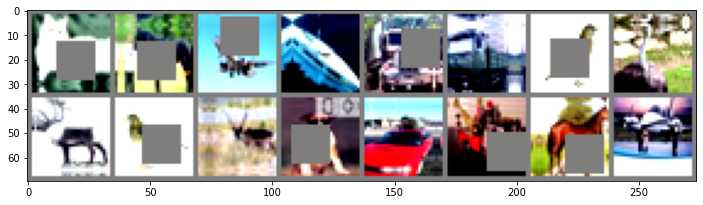

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision 

# functions to show an image
cifar_dataset=train_loader
classes= ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, ax = plt.subplots(figsize=(12, 12))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(cifar_dataset)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16]))

### Model Visualization
Now let's visualize our custom ResNET model which is defined in [eva8_source](https://github.com/devdastl/eva8_source) repo under `/models/custom_resnet.py`.

Since we have already cloned this repo we can directly import it from our directory as mentioned below:

In [4]:
!python -m pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from models.custom_resnet import CustomResNet
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

my_model1 = CustomResNet().to(device)

summary(my_model1, input_size=(3,32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
           Dropout-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
          Dropout-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,456
      BatchNorm2d-14          [-1,

### Setup ModelExecutor module
Now we will setup our main module `ModelExecutor` which will execute training and evaluation on our defined model architecture.

In [6]:
from main import ModelExecuter
import copy
import torch.optim as optim

start_lr = 1e-6
end_lr = 0.1

net = CustomResNet(dropout=0.05).to(device)

criterion = torch.nn.CrossEntropyLoss()

executer_instance = ModelExecuter(criterion=criterion, device='cuda', 
                                  train_loader=train_loader, test_loader=test_loader)

### Find Learning Rate using LRFinder from torch_lr_finder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
Min Loss = 2.062964062988965, Max LR = 0.009770099572992257
LR suggestion: steepest gradient
Suggested LR: 4.13E-05


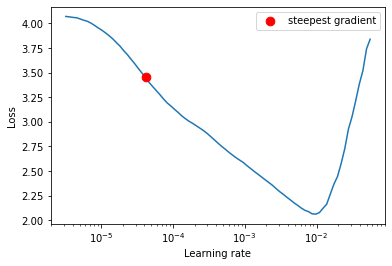

In [7]:
net_exp = copy.deepcopy(net)
optimizer_exp = optim.SGD(net_exp.parameters(), lr=start_lr, momentum=0.90, weight_decay=0.005)

min_loss, max_lr= executer_instance.find_lr(net_exp, optimizer_exp, end_lr=end_lr, num_iter=100, step_mode='exp')

### setup scheduler and start training loop

In [8]:
EPOCH = 24
optimizer=torch.optim.SGD(net.parameters(), lr=start_lr, momentum=0.90, weight_decay=0.005)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader),
                                                epochs=EPOCH, pct_start=5/EPOCH, div_factor=10, three_phase=False, final_div_factor=10, anneal_strategy='linear')

lr_hist = executer_instance.execute_training(net, optimizer=optimizer, scheduler=scheduler, NUM_EPOCH=24)

EPOCH: 1


Loss=1.4624662399291992 Batch_id=97 Accuracy=33.06: 100%|██████████| 98/98 [00:27<00:00,  3.59it/s]



Test set: Average loss: 0.0030, Accuracy: 4719/10000 (47.19%)

EPOCH: 2


Loss=1.3029029369354248 Batch_id=97 Accuracy=51.16: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]



Test set: Average loss: 0.0026, Accuracy: 5379/10000 (53.79%)

EPOCH: 3


Loss=1.211543321609497 Batch_id=97 Accuracy=58.68: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]



Test set: Average loss: 0.0020, Accuracy: 6327/10000 (63.27%)

EPOCH: 4


Loss=0.9354430437088013 Batch_id=97 Accuracy=64.36: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]



Test set: Average loss: 0.0018, Accuracy: 6881/10000 (68.81%)

EPOCH: 5


Loss=0.9018999934196472 Batch_id=97 Accuracy=67.89: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]



Test set: Average loss: 0.0017, Accuracy: 7097/10000 (70.97%)

EPOCH: 6


Loss=0.658655047416687 Batch_id=97 Accuracy=71.22: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]



Test set: Average loss: 0.0014, Accuracy: 7613/10000 (76.13%)

EPOCH: 7


Loss=0.7114944458007812 Batch_id=97 Accuracy=74.49: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]



Test set: Average loss: 0.0012, Accuracy: 7992/10000 (79.92%)

EPOCH: 8


Loss=0.562332808971405 Batch_id=97 Accuracy=76.17: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s]



Test set: Average loss: 0.0012, Accuracy: 8025/10000 (80.25%)

EPOCH: 9


Loss=0.5957327485084534 Batch_id=97 Accuracy=77.75: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]



Test set: Average loss: 0.0010, Accuracy: 8247/10000 (82.47%)

EPOCH: 10


Loss=0.4884718060493469 Batch_id=97 Accuracy=79.22: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]



Test set: Average loss: 0.0010, Accuracy: 8247/10000 (82.47%)

EPOCH: 11


Loss=0.5239384174346924 Batch_id=97 Accuracy=80.36: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]



Test set: Average loss: 0.0009, Accuracy: 8423/10000 (84.23%)

EPOCH: 12


Loss=0.49914100766181946 Batch_id=97 Accuracy=81.51: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]



Test set: Average loss: 0.0009, Accuracy: 8509/10000 (85.09%)

EPOCH: 13


Loss=0.5030393004417419 Batch_id=97 Accuracy=82.27: 100%|██████████| 98/98 [00:27<00:00,  3.62it/s]



Test set: Average loss: 0.0009, Accuracy: 8382/10000 (83.82%)

EPOCH: 14


Loss=0.47417527437210083 Batch_id=97 Accuracy=82.80: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]



Test set: Average loss: 0.0009, Accuracy: 8467/10000 (84.67%)

EPOCH: 15


Loss=0.36743390560150146 Batch_id=97 Accuracy=83.91: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]



Test set: Average loss: 0.0009, Accuracy: 8618/10000 (86.18%)

EPOCH: 16


Loss=0.4529176354408264 Batch_id=97 Accuracy=84.64: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]



Test set: Average loss: 0.0008, Accuracy: 8595/10000 (85.95%)

EPOCH: 17


Loss=0.38791248202323914 Batch_id=97 Accuracy=85.27: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]



Test set: Average loss: 0.0008, Accuracy: 8650/10000 (86.50%)

EPOCH: 18


Loss=0.41050398349761963 Batch_id=97 Accuracy=86.12: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]



Test set: Average loss: 0.0008, Accuracy: 8713/10000 (87.13%)

EPOCH: 19


Loss=0.3342881500720978 Batch_id=97 Accuracy=86.60: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s]



Test set: Average loss: 0.0007, Accuracy: 8787/10000 (87.87%)

EPOCH: 20


Loss=0.38533949851989746 Batch_id=97 Accuracy=87.53: 100%|██████████| 98/98 [00:27<00:00,  3.62it/s]



Test set: Average loss: 0.0006, Accuracy: 8914/10000 (89.14%)

EPOCH: 21


Loss=0.31344231963157654 Batch_id=97 Accuracy=87.96: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]



Test set: Average loss: 0.0006, Accuracy: 8923/10000 (89.23%)

EPOCH: 22


Loss=0.3869306445121765 Batch_id=97 Accuracy=88.57: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]



Test set: Average loss: 0.0006, Accuracy: 8993/10000 (89.93%)

EPOCH: 23


Loss=0.3095790147781372 Batch_id=97 Accuracy=89.23: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]



Test set: Average loss: 0.0006, Accuracy: 9026/10000 (90.26%)

EPOCH: 24


Loss=0.2835022509098053 Batch_id=97 Accuracy=89.74: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]


generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24

Test set: Average loss: 0.0005, Accuracy: 9063/10000 (90.63%)



### Visualize results

##### Accuracy and loss plot for train and test valization set

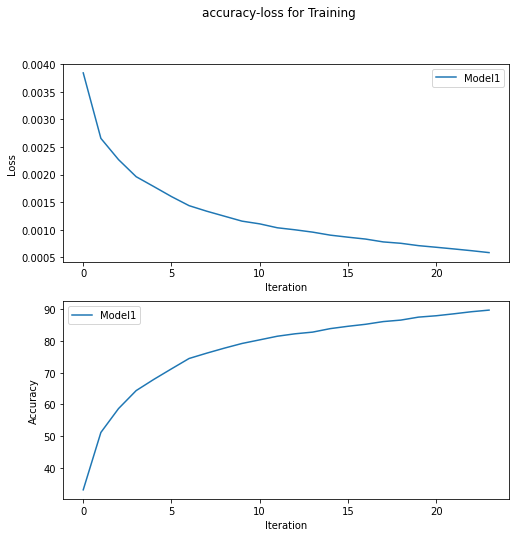

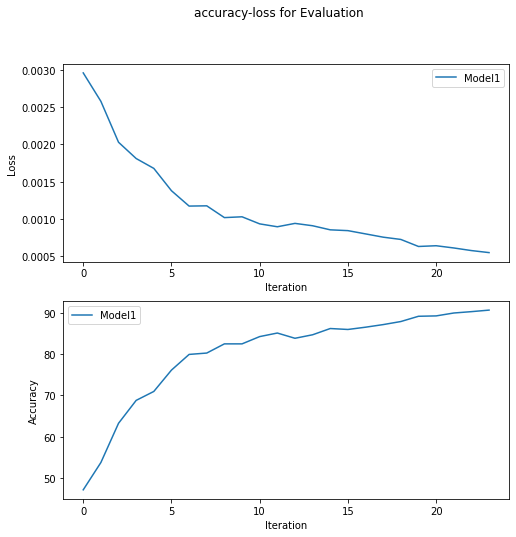

In [9]:
executer_instance.plot_graph()

#### Plot misclassified images

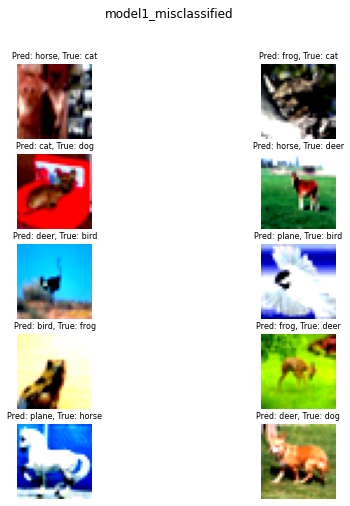

In [10]:
executer_instance.plot_misclassified()

#### Plot gradCAM of misclassified images

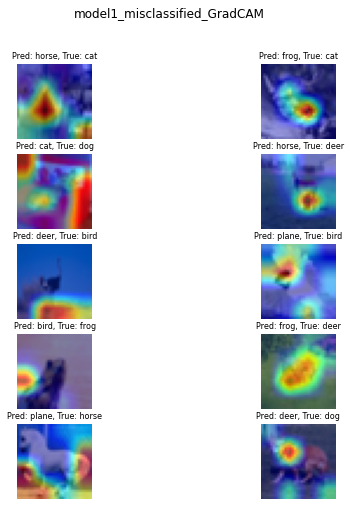

In [11]:
executer_instance.plot_misclassified_grad()